<a href="https://colab.research.google.com/github/mgorkemuysal/Intel-Image-Classification-Keras-CNN/blob/master/intel_image_classification_keras_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading and Preparing the Data**
Download image data from Kaggle using kaggle.json file




In [1]:
import os 
os.environ['KAGGLE_USERNAME'] = "mgorkemuysal"
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY_FROM_KAGGLE.JSON"
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 336M/346M [00:04<00:00, 77.2MB/s]
100% 346M/346M [00:04<00:00, 85.7MB/s]


In [0]:
from zipfile import ZipFile
with ZipFile('intel-image-classification.zip', 'r') as zip:
  # zip.printdir()
  zip.extractall()

In [3]:
!ls

intel-image-classification.zip	sample_data  seg_pred  seg_test  seg_train


# **Inspecting Directories and Number of Images**
Training and Test directories have buildings, forest, glacier, mountain, sea and street subdirectories. In Keras, we can use subdirectories as 'labels'. So, we can say that our problem is multiclass classification problem. We should split training images to use validation later.

In [4]:
train_dir = './seg_train/seg_train/'
test_dir = './seg_test/seg_test/'

print('\t--- TRAINING IMAGES ---\n')
print('Number of training building images:', len(os.listdir(os.path.join(train_dir, 'buildings'))))
print('Number of training forest images:', len(os.listdir(os.path.join(train_dir, 'forest'))))
print('Number of training glacier images:', len(os.listdir(os.path.join(train_dir, 'glacier'))))
print('Number of training mountain images:', len(os.listdir(os.path.join(train_dir, 'mountain'))))
print('Number of training sea images:', len(os.listdir(os.path.join(train_dir, 'sea'))))
print('Number of training street images:', len(os.listdir(os.path.join(train_dir, 'street'))))
print('\n\t--- TEST IMAGES ---\n')
print('Number of test building images:', len(os.listdir(os.path.join(test_dir, 'buildings'))))
print('Number of test forest images:', len(os.listdir(os.path.join(test_dir, 'forest'))))
print('Number of test glacier images:', len(os.listdir(os.path.join(test_dir, 'glacier'))))
print('Number of test mountain images:', len(os.listdir(os.path.join(test_dir, 'mountain'))))
print('Number of test sea images:', len(os.listdir(os.path.join(test_dir, 'sea'))))
print('Number of test street images:', len(os.listdir(os.path.join(test_dir, 'street'))))

	--- TRAINING IMAGES ---

Number of training building images: 2191
Number of training forest images: 2271
Number of training glacier images: 2404
Number of training mountain images: 2512
Number of training sea images: 2274
Number of training street images: 2382

	--- TEST IMAGES ---

Number of test building images: 437
Number of test forest images: 474
Number of test glacier images: 553
Number of test mountain images: 525
Number of test sea images: 510
Number of test street images: 501


# **Data Preprocessing**
Before construct and train our model, we need data preprocessing. First thing to do rescale the pixel values (between 0 and 255) to the [0, 1] interval (neural networks prefer to deal with small input values) and split our train images into validation subset. Also we need to use class_mode = 'categorical' because we have multiclass classification problem. Thanks to data processing we can read the picture files, decode the JPEG content to RGB grids of pixels, convert these into floating-point tensors.



In [40]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.25)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory (
    directory = train_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64,
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory (
    directory = train_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory (
    directory = test_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 10528 images belonging to 6 classes.
Found 3506 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# **Building Network**
The Model consists of Conv2D, MaxPooling2D, Flatten and Dense layers with (150, 150, 3) input shape (height, width, rgb), ReLU and softmax activation functions. Because we have a multiclass-classification problem, the model end with 6 unit and softmax activation function.

In [0]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(6, activation = 'softmax'))

# **Configuring the model for Training**
Because we have multiclass-classification problem, we need to use categorical_crossentropy loss function.

In [0]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['acc']
)

# **Fitting the model using Batch Generator**
We can fit the model using fit_generator method includes train_generator, validation_generator, epocs and batch sizes per epoch (image_number / batch_size) 

In [43]:
history = model.fit_generator (
    train_generator,
    steps_per_epoch = int(10528/64),
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = int(3506/64)
)

Epoch 1/50
164/164 [==============================] - 15s 89ms/step - loss: 1.3536 - acc: 0.4862 - val_loss: 0.7181 - val_acc: 0.6183
Epoch 2/50
164/164 [==============================] - 14s 88ms/step - loss: 0.9301 - acc: 0.6435 - val_loss: 0.9098 - val_acc: 0.6732
Epoch 3/50
164/164 [==============================] - 14s 88ms/step - loss: 0.7679 - acc: 0.7134 - val_loss: 0.6650 - val_acc: 0.7220
Epoch 4/50
164/164 [==============================] - 14s 88ms/step - loss: 0.6350 - acc: 0.7636 - val_loss: 0.4665 - val_acc: 0.7804
Epoch 5/50
164/164 [==============================] - 15s 89ms/step - loss: 0.5385 - acc: 0.8045 - val_loss: 0.3958 - val_acc: 0.8004
Epoch 6/50
164/164 [==============================] - 15s 89ms/step - loss: 0.4606 - acc: 0.8337 - val_loss: 0.7773 - val_acc: 0.7580
Epoch 7/50
164/164 [==============================] - 15s 89ms/step - loss: 0.3624 - acc: 0.8700 - val_loss: 0.5084 - val_acc: 0.7841
Epoch 8/50
164/164 [==============================] - 15s 89ms

# **Visualizing the Performance of the Model**
We can clearly see that the model is overfitting (High accuracy - Low Loss and Low Validation Accuracy - High Validation Loss). So, we must update our model and preprocessing process to get rid of the overfitting.

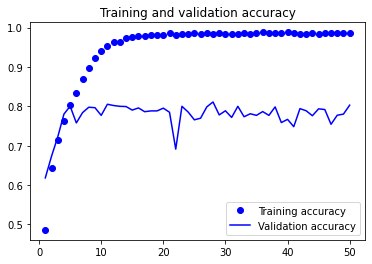

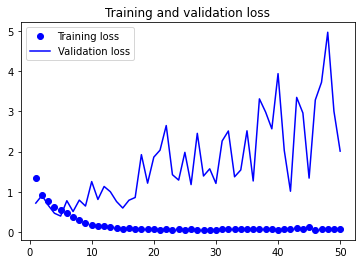

In [44]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Adding Dropout to Network**
Dropout  is  one  of  the  most  effective  and  most  commonly  used  regularization  tech-niques for neural networks. Dropout,  applied  to  a  layer,  consists  of  randomly  dropping  out(setting to zero) a number of output features of the layer during training. 

In [0]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(6, activation = 'softmax'))

Using TensorFlow backend.


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

# **Using Data Augmentation**
Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Data augmentation takes the approach of generating more training datafrom  existing  training  samples, by augmenting the samples via a number of random transformations that yield believable-looking images.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.25
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory (
    directory = train_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64,
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory (
    directory = train_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory (
    directory = test_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Using TensorFlow backend.


Found 10528 images belonging to 6 classes.
Found 3506 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [0]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['acc']
)

# **Using Callbacks**

Thanks to the ReduceLROnPlateau(), if the model in training process gets stuck local minimum, we can multiply learning rate by factor value. To do this ReduceLROnPlateau() watches val_loss through training process. This may increase the performance of the model.

In [0]:
from keras.callbacks import ReduceLROnPlateau

callback_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto') 

history = model.fit_generator (
    train_generator,
    steps_per_epoch = int(10528/64),
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = int(3506/64),
    callbacks = [callback_reduce]
)

Epoch 1/50
164/164 [==============================] - 88s 539ms/step - loss: 1.3932 - acc: 0.4432 - val_loss: 1.1687 - val_acc: 0.5816
Epoch 2/50
164/164 [==============================] - 87s 532ms/step - loss: 1.1110 - acc: 0.5707 - val_loss: 1.0424 - val_acc: 0.6104
Epoch 3/50
164/164 [==============================] - 88s 539ms/step - loss: 1.0050 - acc: 0.6191 - val_loss: 0.8506 - val_acc: 0.6200
Epoch 4/50
164/164 [==============================] - 89s 543ms/step - loss: 0.9369 - acc: 0.6466 - val_loss: 0.7908 - val_acc: 0.6894
Epoch 5/50
164/164 [==============================] - 87s 530ms/step - loss: 0.8879 - acc: 0.6651 - val_loss: 0.7723 - val_acc: 0.7074
Epoch 6/50
164/164 [==============================] - 87s 533ms/step - loss: 0.8395 - acc: 0.6861 - val_loss: 0.8594 - val_acc: 0.6955
Epoch 7/50
164/164 [==============================] - 88s 538ms/step - loss: 0.8094 - acc: 0.7043 - val_loss: 0.8651 - val_acc: 0.7199
Epoch 8/50
164/164 [==============================] - 8

# **Visualizing and Testing the new Model**
Thanks to the dropout layer and data augmentation, we can clearly see that the new model is not overfitting (acc - vall_acc and loss - val_loss are similar). Testing result of the new model is %84. 

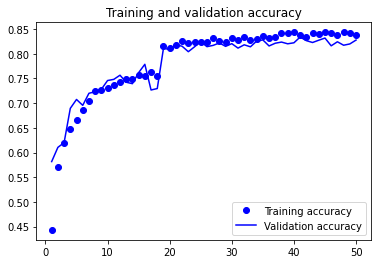

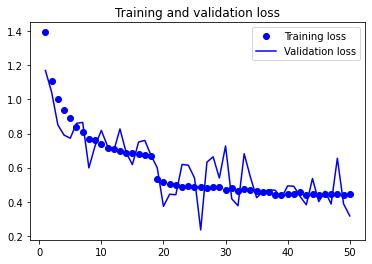

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))
print('Accuracy of the model on the test set: ',accuracy[1])

Accuracy of the model on the test set:  0.843999981880188


# **Using Pretrained Convolutional Network**
A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. So, using a pretrained network, we can expect to take better results. 
In this case, I am going to use VGG16 network with freezing (trainable = False). Freezing a layer or set of layers means preventing their weights from beingupdated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would bepropagated through the network, effectively destroying the representations previously learned.

In [27]:
from keras.applications import VGG16
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
base_model.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [28]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# **Building a Network from Pretrained Network**
Adding densely-connected layers to pretrained VGG16 network. To do so, I build a network to use my multiclass-classification problem (6 units and softmax activation function in the last layer).  

In [29]:
from keras import models, layers

model_vgg16 = models.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(512, activation = 'relu'))
model_vgg16.add(layers.Dense(6, activation = 'softmax'))

model_vgg16.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 3078      
Total params: 18,912,582
Trainable params: 4,197,894
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
from keras import optimizers
model_vgg16.compile(loss = 'categorical_crossentropy',
                    optimizer = optimizers.RMSprop(lr=2e-5),
                    metrics=['acc'])

In [36]:
history_vgg16 = model_vgg16.fit_generator (
    train_generator,
    steps_per_epoch = int(10528/64),
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = int(3506/64)
)

Epoch 1/50
164/164 [==============================] - 81s 492ms/step - loss: 0.9580 - acc: 0.6843 - val_loss: 0.8025 - val_acc: 0.7575
Epoch 2/50
164/164 [==============================] - 81s 492ms/step - loss: 0.6223 - acc: 0.7823 - val_loss: 0.7256 - val_acc: 0.7990
Epoch 3/50
164/164 [==============================] - 80s 490ms/step - loss: 0.5534 - acc: 0.8052 - val_loss: 0.4569 - val_acc: 0.8030
Epoch 4/50
164/164 [==============================] - 80s 489ms/step - loss: 0.5269 - acc: 0.8137 - val_loss: 0.6116 - val_acc: 0.8074
Epoch 5/50
164/164 [==============================] - 80s 488ms/step - loss: 0.5077 - acc: 0.8168 - val_loss: 0.6543 - val_acc: 0.8173
Epoch 6/50
164/164 [==============================] - 80s 486ms/step - loss: 0.4917 - acc: 0.8230 - val_loss: 0.5047 - val_acc: 0.8251
Epoch 7/50
164/164 [==============================] - 79s 482ms/step - loss: 0.4811 - acc: 0.8244 - val_loss: 0.4535 - val_acc: 0.8225
Epoch 8/50
164/164 [==============================] - 7

# **Visualizing and Testing the Model**
Using pretrained VGG16 network, the model have better training, validation and testing results. 

In [38]:
accuracy = model_vgg16.evaluate_generator(test_generator, steps=len(test_generator))
print('Accuracy of the model on the test set: ',accuracy[1])

Accuracy of the model on the test set:  0.871666669845581


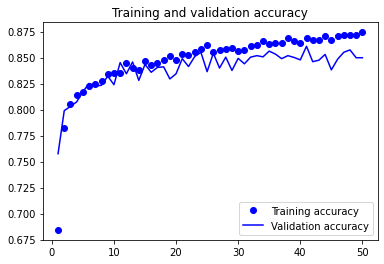

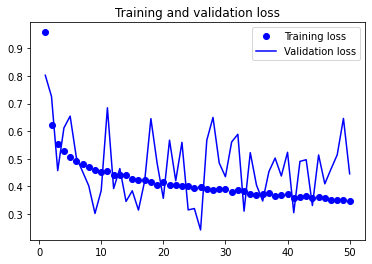

In [37]:
import matplotlib.pyplot as plt

acc = history_vgg16.history['acc']
val_acc = history_vgg16.history['val_acc']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()